# Check detectorMap (for bootstrap, ...)

In [1]:
%load_ext autoreload
 
%autoreload 2

In [2]:
from datetime import datetime
import os
import pandas as pd
import math
import numpy as np

In [3]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
from pfs.drp.stella import DetectorMap
from pfs.drp.stella.utils import addPfsCursor
from pfs.datamodel.pfsConfig import *


In [4]:
from pfs.drp.stella.utils import showDetectorMap

In [5]:
afwDisplay.setDefaultBackend("matplotlib")

In [6]:
from align import *

In [7]:
from pfs.lam.opdb import getVisitRange
from pfs.lam.imageAnalysis import estimateCOM, fitparabola
from pfs.lam.linePeaksList import filterPeakList

In [8]:
import matplotlib.pyplot as plt

#plt.rcParams["figure.facecolor"] = "white" 

In [9]:
%matplotlib ipympl

In [11]:
#define where plots will be saved
imgPath = "/work/fmadec/analysis/sm1/"

In [12]:
if os.path.exists(imgPath) is False:
    print(f"create foler {imgPath}")
    os.makedirs(imgPath, exist_ok=True)

In [13]:
savePlot = False

# Butler and Data
Define: ExpId/visitId arm and specId

In [14]:
base, rerun = "/work/drp/", "drpActor/CALIB"
#base, rerun = "/data/drp/sps", "fmadec/sm2/r2"


dataDir = os.path.join(base, "rerun", rerun) if rerun else base
calibRoot = "/work/drp/CALIB/"

butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)

/tmp/ipykernel_65690/4064802442.py:8: FutureWarning: Gen2 Butler has been deprecated (PfsButler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)
/tmp/ipykernel_65690/4064802442.py:8: FutureWarning: Gen2 Butler has been deprecated (PfsMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)


lsst.CameraMapper INFO: Loading exposure registry from /work/drp/registry.pgsql
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3


In [98]:
site = "Subaru"
specId = 1
arm = "n"
#expId = 3396
cam = f"{arm}{specId}"

visit = 101852

In [101]:
dataId = dict(visit=visit, arm=arm, spectrograph=specId)
exp = butler.get("calexp", dataId)

In [102]:
# detectormap
#detMap = butler.get('detectorMap', dataId)
# or 
#detMap = DetectorMap.readFits("/work/drp/rerun/fmadec/sm1/bootstrap/DETECTORMAP/pfsDetectorMap-101822-n1.fits")
detMap = DetectorMap.readFits("/work/drp/CALIB/DETECTORMAP/pfsDetectorMap-096921-n1.fits")


simMap = DetectorMap.readFits("/work/drp/CALIB/DETECTORMAP/pfsDetectorMap-000000-n1.fits")
    

In [103]:
#rbutler = dafPersist.Butler(f"{dataDir}")
butler.getKeys('raw')
lamps = butler.queryMetadata('raw', ['lamps'], visit=visit, arm=arm) 
print(lamps)

['Ar']


In [104]:
pfsConfig = butler.get("pfsConfig", dataId).select(spectrograph=specId)
pfsConfig = pfsConfig[pfsConfig.targetType == TargetType.DCB]
fiberIds = pfsConfig.fiberId[pfsConfig.spectrograph == specId]

/work/stack_INFRA-312/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/drp_stella/w.2023.37/python/pfs/drp/stella/utils/display.py:219: UserWarning: addPfsCursor: Using an old version of display_matplotlib. Ideally need one that has the method DisplayImpl.set_format_coord. Using workaround.
  warnings.warn("addPfsCursor: Using an old version of display_matplotlib. "


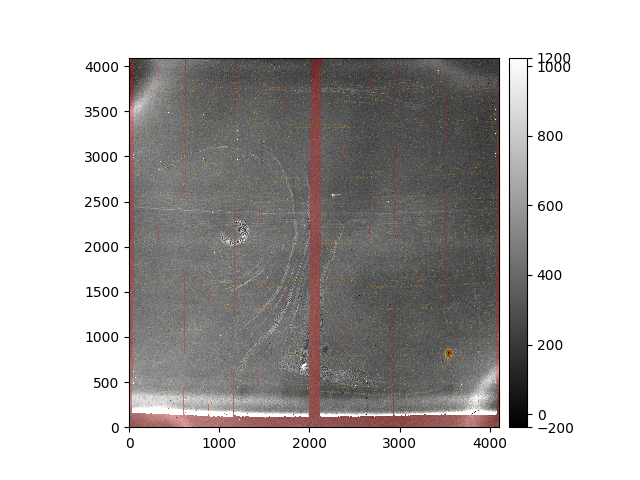

In [105]:
fig = 1; plt.close(fig); fig = plt.figure(fig)

display = afwDisplay.Display(fig)
display.scale("linear", min="zscale")
display.mtv(exp)
addPfsCursor(display, detectorMap=detMap)

In [106]:

from pfs.drp.stella.readLineList import ReadLineListTask, ReadLineListConfig


In [107]:
lines = ReadLineListTask().run(detectorMap=detMap, metadata=exp.getMetadata())
#select = (lines.status & status) != 0  # Bit is set for status flags

In [108]:
from pfs.drp.stella.referenceLine import ReferenceLineStatus
status = ReferenceLineStatus.LAM_FOCUS | ReferenceLineStatus.LAM_IMAGEQUALITY  # Selecting both kinds of LAM flags
select = (lines.status & status) != 0  # Bit is set for status flags

In [109]:
select

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [111]:
len(select)

26

In [82]:
lines[select].wavelength

array([966.0435])

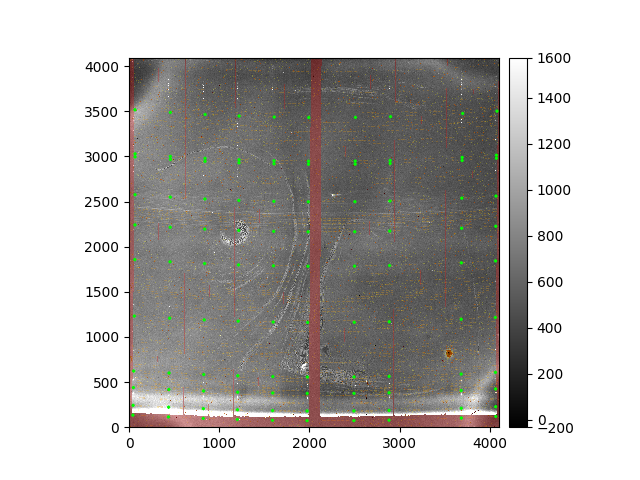

In [83]:
detMap.display(display, fiberId=pfsConfig.fiberId, wavelengths=lines[select].wavelength, plotTraces=False);
#detMap.display(display, fiberId=pfsConfig.fiberId, plotTraces=False);

In [39]:
detMap.display(display, fiberId=pfsConfig.fiberId, wavelengths=select, plotTraces=False);
#detMap.display(display, fiberId=pfsConfig.fiberId, plotTraces=False);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

# plot image with simulation detectorMap

/work/stack_INFRA-312/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/drp_stella/w.2023.37/python/pfs/drp/stella/utils/display.py:219: UserWarning: addPfsCursor: Using an old version of display_matplotlib. Ideally need one that has the method DisplayImpl.set_format_coord. Using workaround.
  warnings.warn("addPfsCursor: Using an old version of display_matplotlib. "


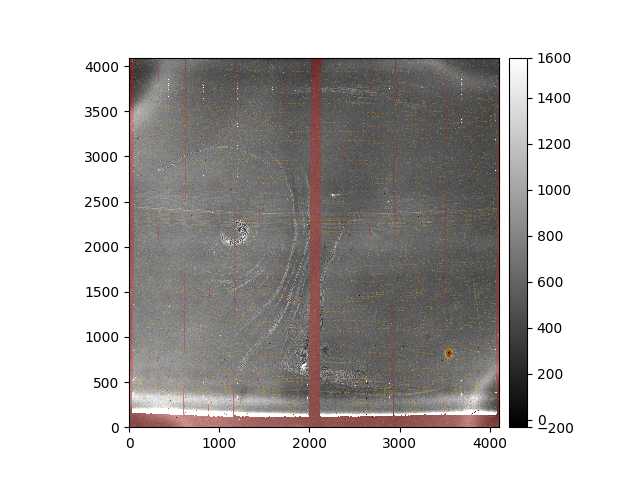

In [37]:
fig = 1; plt.close(fig); fig = plt.figure(fig)

display2 = afwDisplay.Display(fig)
display2.scale("linear", min="zscale")
display2.mtv(exp)
addPfsCursor(display2, detectorMap=simMap)

In [44]:
#simMap.display(display2, fiberId=pfsConfig.fiberId, wavelengths=lines.wavelength, plotTraces=False);
simMap.display(display2, fiberId=pfsConfig.fiberId, wavelengths=select, plotTraces=False);

#detMap.display(display, fiberId=pfsConfig.fiberId, plotTraces=False);